<a href="https://colab.research.google.com/github/samyon7/ML/blob/master/TextGeneration_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>TEXT GENERATION</b>
--
AUTHOR : HAMORA HADI

In [13]:
import pandas as pd
import numpy as np
import pickle
import re
import random
from tqdm import tqdm_notebook

import torch
from torch import nn
import torch.nn.functional as F
import matplotlib

In [15]:
SEED = 2019
torch.manual_seed(SEED)

In [16]:
from google.colab import files
uploaded = files.upload()

Saving Dailog-dataset.dialogs_dataset to Dailog-dataset.dialogs_dataset


In [17]:
with open("Dailog-dataset.dialogs_dataset", "rb") as f:
  dialogs = pickle.load(f)

In [21]:
dialogs_clean = []

for i in dialogs:
  i = re.sub("[^a-zA-Z' ]", "", i)  # remove everything except alphabets
  i = i.lower()                     # convert text to lowercase
  dialogs_clean.append(i)           # add cleaned text to the list

In [22]:
all_words = " ".join(dialogs_clean).split() #List of all words!

In [25]:
words_dict = {}

for word in all_words:   
  if word in words_dict:
    words_dict[word] = words_dict[word] + 1
  else:
    words_dict[word] = 1

total_values = words_dict.values()
print(sum(total_values))

475893


In [28]:
words_df = pd.DataFrame({'word':list(words_dict.keys()), 'count':list(words_dict.values())}) # Prepare a dataframe
words_df = words_df.sort_values(by = ['count'])                                              # Sort words
words_df.reset_index(inplace = True, drop=True)                                              # Reset dataframe index

In [30]:
rare_thresh = 4

# Get percentage of rare words in the vocabulary
rare_words_count = len(words_df[words_df['count'] < rare_thresh]['word'])
total_words = len(words_df) 
rare_dist = rare_words_count / total_words

rare_cover = words_df[words_df['count'] < rare_thresh]['count'].sum()/words_df['count'].sum() # Coverage percentage of rare words in the corpus

In [32]:
print(f"Rare words distribution in the vocabulary: {rare_dist*100:.2f}")
print(f"Rare words coverage in the corpus: {rare_cover*100:.2f}")

Rare words distribution in the vocabulary: 69.03
Rare words coverage in the corpus: 2.27


In [33]:
rare_words = words_df[words_df['count'] < rare_thresh]['word'].tolist()

In [36]:
#Let's see the technique that we will use to replace the rare words/tokens in the dataset with a special token known as the unknown token
pattern = ""
for i in rare_words:
  pattern+= " {} |".format(i)

pattern = pattern[:-1]
dialogs_clean_v2 = []

for d in tqdm_notebook(dialogs_clean):
  text = re.sub(pattern, " <unk> ", d)
  dialogs_clean_v2.append(text) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [38]:
dialogs_clean_v2[500:530]

['alright that is perfect',
 "no i'm not going to be picky since that is the only showing for the rest of the night",
 ' i just want to see it',
 'cool i got them',
 'thanks i will',
 'hi i have something wrong with my car and i need to make an appointment to fix it',
 'intelligent auto solutions on west street in boston mass',
 'one of my headlights is out',
 ' i need it replaced',
 'as soon as they can get me in',
 'that sounds great',
 "yeah that's fine",
 'yeah go ahead and book the appointment',
 "i'd like to get two tickets for alita battle angel",
 "i'm planning on watching it in cheektowaga",
 'what show times are there ',
 "i'm taking my friend there on friday",
 'what showtimes do they have at night ',
 'tell me good chinese restaurants in new york',
 'which one is near to airport ',
 'does it serve traditional chinese dessert',
 'how much extra time to reach <unk> ',
 'ok lets reserve a table for dinner at hakkasan',
 'hello i need to get a car please',
 'holiday inn <unk> p

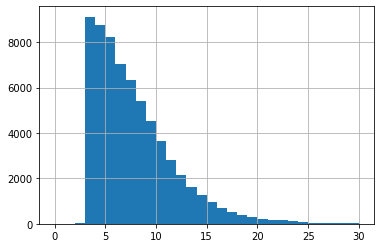

In [39]:
#Plot the sequences

text_word_count = []
for i in dialogs_clean_v2:
  text_word_count.append(len(i.split()))
        
pd.Series(text_word_count).hist(bins = 30,range=(0,30))

EQUAL LENGTH!

In [40]:
def create_seq(text, seq_len = 5):
      
  sequences = []    
  
  if len(text.split()) > seq_len:
    for i in range(seq_len, len(text.split())):
      seq = text.split()[i-seq_len:i+1]
      sequences.append(" ".join(seq))

    return sequences

  else:
    
    return [text]

In [51]:
seqs = [create_seq(i) for i in dialogs_clean_v2]  # Create sequences of equal length
seqs[0:7]

[["hi i'm looking to book a",
  "i'm looking to book a table",
  'looking to book a table for',
  'to book a table for korean',
  'book a table for korean fod'],
 ['somewhere in southern nyc maybe the',
  'in southern nyc maybe the east',
  'southern nyc maybe the east village'],
 ["we don't want to sit at",
  "don't want to sit at the",
  'want to sit at the bar',
  'to sit at the bar but',
  'sit at the bar but anywhere',
  'at the bar but anywhere else',
  'the bar but anywhere else is',
  'bar but anywhere else is fine'],
 ['what times are available'],
 ["yikes we can't do those times"],
 ['let me check'],
 ["great let's book that"]]

In [52]:
# Merge list-of-lists into a single list
seqs = sum(seqs, [])

In [54]:
seqs[:2]

["hi i'm looking to book a", "i'm looking to book a table"]

In [55]:
len(seqs)

205346

In [62]:
x = []
y = []

for s in seqs:
  x.append(" ".join(s.split()[:-1]))
  y.append(" ".join(s.split()[1:]))

print(x[0], y[0])
print(x[88543], y[88543])

hi i'm looking to book i'm looking to book a
to drive to several locations drive to several locations do


TOKENIZE WITH INTEGER MAPPING!

In [64]:
int2token = {}
cnt = 1

for w in set(" ".join(dialogs_clean_v2).split()):
  int2token[cnt] = w
  cnt+= 1

token2int = {t: i for i, t in int2token.items()}

token2int["can"], int2token[1127]

(4782, 'recieve')

In [66]:
#Now, split data into train and validation!
x_tr = x[:150000]
x_val = x[150000:]

y_tr = y[:150000]
y_val = y[150000:]

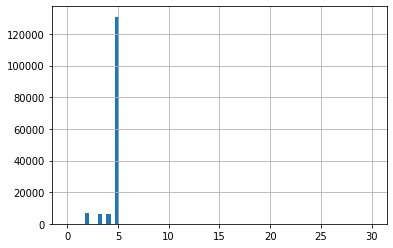

In [68]:
#VISUALIZE PAD SEQUENCES!

text_word_count = []

for i in x_tr:
  text_word_count.append(len(i.split()))

pd.Series(text_word_count).hist(bins = 70,range=(0,30))

In [69]:
max_text_len = 5

def pad_sequence(seq, n):

  seq = seq.split()
  
  if len(seq) < n:
    for i in range(n - len(seq)):
      seq.append("<pad>")

  return " ".join(seq)

# pad text sequences (train set)
x_tr_padded = [pad_sequence(s, max_text_len) for s in x_tr]
y_tr_padded = [pad_sequence(s, max_text_len) for s in y_tr]

# pad text sequences (validation set)
x_val_padded = [pad_sequence(s, max_text_len) for s in x_val]
y_val_padded = [pad_sequence(s, max_text_len) for s in y_val]

In [71]:
x_tr_padded[:20]

["hi i'm looking to book",
 "i'm looking to book a",
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'somewhere in southern nyc maybe',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 "we don't want to sit",
 "don't want to sit at",
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but',
 'at the bar but anywhere',
 'the bar but anywhere else',
 'bar but anywhere else is',
 'what times are <pad> <pad>',
 "yikes we can't do those",
 'let me <pad> <pad> <pad>',
 "great let's book <pad> <pad>"]

In [72]:
y_tr_padded[:20]

["i'm looking to book a",
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'a table for korean fod',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 'nyc maybe the east village',
 "don't want to sit at",
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but',
 'at the bar but anywhere',
 'the bar but anywhere else',
 'bar but anywhere else is',
 'but anywhere else is fine',
 'times are available <pad> <pad>',
 "we can't do those times",
 'me check <pad> <pad> <pad>',
 "let's book that <pad> <pad>"]

In [74]:
int2token[0] = "<pad>"
token2int["<pad>"] = 0

vocab_size = len(int2token)
len(int2token)

6502

In [79]:
#Convert text into integer sequences
def get_integer_seq(seq):
  return [token2int[w] for w in seq.split()]

x_tr_int = [get_integer_seq(i) for i in x_tr_padded]
y_tr_int = [get_integer_seq(i) for i in y_tr_padded]

x_val_int = [get_integer_seq(i) for i in x_val_padded]
y_val_int = [get_integer_seq(i) for i in y_val_padded]

#USE CODE BELOW FOR WINDOWS USER!

# x_tr_int = torch.tensor(x_tr_int).to(torch.int64)
# y_tr_int = torch.tensor(y_tr_int).to(torch.int64)

# x_val_int = torch.tensor(x_val_int).to(torch.int64)
# y_val_int = torch.tensor(y_val_int).to(torch.int64)

In [80]:
x_tr_int[:10]

[[3177, 4925, 2447, 2751, 2091],
 [4925, 2447, 2751, 2091, 1377],
 [2447, 2751, 2091, 1377, 3673],
 [2751, 2091, 1377, 3673, 4968],
 [2091, 1377, 3673, 4968, 3974],
 [3545, 3, 1906, 90, 377],
 [3, 1906, 90, 377, 6275],
 [1906, 90, 377, 6275, 4014],
 [3746, 4100, 1534, 2751, 758],
 [4100, 1534, 2751, 758, 5188]]

In [81]:
y_tr_int[:10]

[[4925, 2447, 2751, 2091, 1377],
 [2447, 2751, 2091, 1377, 3673],
 [2751, 2091, 1377, 3673, 4968],
 [2091, 1377, 3673, 4968, 3974],
 [1377, 3673, 4968, 3974, 4940],
 [3, 1906, 90, 377, 6275],
 [1906, 90, 377, 6275, 4014],
 [90, 377, 6275, 4014, 3998],
 [4100, 1534, 2751, 758, 5188],
 [1534, 2751, 758, 5188, 6275]]

In [83]:
#From list to array of numpy!
x_tr_int = np.array(x_tr_int)
y_tr_int = np.array(y_tr_int)

x_val_int = np.array(x_val_int)
y_val_int = np.array(y_val_int)

x_tr_int.shape, y_tr_int.shape, x_val_int.shape, y_val_int.shape

((150000, 5), (150000, 5), (55346, 5), (55346, 5))

In [84]:
x_tr_int[:1]

array([[3177, 4925, 2447, 2751, 2091]])

<b>BUILD!</b>

In [85]:
#Define first your model architecture!

In [87]:
class WordLSTM(nn.Module):
      
  def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.3, lr=0.001):
    super().__init__()
    self.drop_prob = drop_prob
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.lr = lr
    
    self.emb_layer = nn.Embedding(vocab_size, 200)

    ## define the LSTM
    # input data is of shape (batch size, sequence length, no. of features)...
    # ...therefore we need batch_first=True
    self.lstm = nn.LSTM(200, n_hidden, n_layers, batch_first=True)
    
    ## define a dropout layer
    self.dropout = nn.Dropout(drop_prob)
    
    ## define the fully-connected layer
    self.fc = nn.Linear(n_hidden, vocab_size)      
  
  def forward(self, x, hidden):
    embedded = self.emb_layer(x)     
    lstm_output, hidden = self.lstm(embedded, hidden)
    out = self.dropout(lstm_output)
    ## (batch-size*sequence length, hidden units)
    out = out.reshape(-1, self.n_hidden)
    out = self.fc(out)

    # return the final output and the hidden state
    return out, hidden
    
  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data

    if (torch.cuda.is_available()):
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
    
    return hidden

net = WordLSTM()
print(net)

WordLSTM(
  (emb_layer): Embedding(6502, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=6502, bias=True)
)


In [90]:
#GENERATE BATCHES!
def get_batches(arr_x, arr_y, batch_size):
  prv = 0
  
  for n in range(batch_size, arr_x.shape[0], batch_size):
    x = arr_x[prv:n,:] # batch of input sequences
    y = arr_y[prv:n,:] # batch of target sequences
    prv = n
    
    yield x, y

In [93]:
#Start the training!

def train(net, epochs=10, batch_size=32, lr=0.001, print_every=32):
  best_valid_loss = float('inf')
  opt = torch.optim.Adam(net.parameters(), lr=lr)  # optimizer
  criterion = nn.CrossEntropyLoss() # loss function
  
  if(torch.cuda.is_available()):
    net.cuda() # GPU model
  
  counter = 0

  net.train()

  for e in range(epochs):
    for x, y in get_batches(x_tr_int, y_tr_int, batch_size):
      counter+= 1
      inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
      
      if(torch.cuda.is_available()):
        inputs, targets = inputs.cuda(), targets.cuda() # Push into GPU model
      h = net.init_hidden(batch_size)
      net.zero_grad()
      
      output, h = net(inputs, h)
      loss = criterion(output, targets.view(-1))
      loss.backward()
      
      opt.step()
      
      if counter % print_every == 0:
        val_losses = []

        net.eval()
        for x, y in get_batches(x_val_int, y_val_int, batch_size):
            
          x, y = torch.from_numpy(x), torch.from_numpy(y)
          
          val_h = net.init_hidden(batch_size)

          inputs, targets = x, y
          if(torch.cuda.is_available()):
            inputs, targets = inputs.cuda(), targets.cuda()

          output, val_h = net(inputs, val_h)

          val_loss = criterion(output, targets.view(-1))
          val_losses.append(val_loss.item())

        if np.mean(val_losses) < best_valid_loss:
          best_valid_loss = np.mean(val_losses)
          torch.save(net.state_dict(), 'saved_weights.pt') # save the best model with .pt format!

        net.train()

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.4f}...".format(loss.item()),
              "ppl: {:.4f} ".format(np.exp(np.mean(val_losses))),
              "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [95]:
#NOW TRAIN!

batch_size = 64

# train the model
train(net, batch_size = batch_size, epochs=1) #Set epochs into 10 integers!

Epoch: 1/1... Step: 32... Loss: 6.4212... ppl: 694.5146  Val Loss: 6.5432
Epoch: 1/1... Step: 64... Loss: 5.6675... ppl: 347.7227  Val Loss: 5.8514
Epoch: 1/1... Step: 96... Loss: 6.0697... ppl: 276.6708  Val Loss: 5.6228
Epoch: 1/1... Step: 128... Loss: 5.2529... ppl: 238.4657  Val Loss: 5.4742
Epoch: 1/1... Step: 160... Loss: 6.1836... ppl: 211.2572  Val Loss: 5.3531
Epoch: 1/1... Step: 192... Loss: 5.6900... ppl: 189.0562  Val Loss: 5.2420
Epoch: 1/1... Step: 224... Loss: 5.1771... ppl: 170.8108  Val Loss: 5.1406
Epoch: 1/1... Step: 256... Loss: 4.3070... ppl: 156.5505  Val Loss: 5.0534
Epoch: 1/1... Step: 288... Loss: 4.9102... ppl: 144.7916  Val Loss: 4.9753
Epoch: 1/1... Step: 320... Loss: 4.9714... ppl: 135.2871  Val Loss: 4.9074
Epoch: 1/1... Step: 352... Loss: 4.3756... ppl: 125.8927  Val Loss: 4.8354
Epoch: 1/1... Step: 384... Loss: 5.1166... ppl: 118.0236  Val Loss: 4.7709
Epoch: 1/1... Step: 416... Loss: 4.8671... ppl: 112.3798  Val Loss: 4.7219
Epoch: 1/1... Step: 448... L

In [96]:
from google.colab import files
uploaded = files.upload()

Saving saved_weights.pt to saved_weights (1).pt


In [99]:
path = 'saved_weights.pt'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [101]:
def predict(net, tkn, h=None):
  x = np.array([[token2int[tkn]]])
  inputs = torch.from_numpy(x)
  
  if(torch.cuda.is_available()):
      inputs = inputs.cuda()
  out, h = net(inputs, h)
  p = F.softmax(out, dim=1).data

  if(torch.cuda.is_available()):
      p = p.cpu()

  p = p.numpy()
  sampled_token_index = np.argmax(p, axis = 1)[0]
  return int2token[sampled_token_index], h

def sample(net, size = 2, seed_text='it is'):
        
    if(torch.cuda.is_available()):
        net.cuda()
    
    net.eval()
    h = net.init_hidden(1)
    toks = seed_text.split()
    for t in toks:
      token, h = predict(net, t, h)
    
    toks.append(token)
    for i in range(size-1):
        token, h = predict(net, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

In [112]:
seeds = ["i will",
         "how about a cup",
         "i don't want",
         "can you send",
         "my girlfriend",
         "so"]

num_toks = 7

for s in seeds:
  text_gen = sample(net, num_toks, seed_text=s)
  print("Your text :", s, ">> Generated => ",text_gen)
  print("\n")

Your text : i will >> Generated =>  i will be able to get a ride from


Your text : how about a cup >> Generated =>  how about a cup of espresso and a large pizza with


Your text : i don't want >> Generated =>  i don't want to be picked up at the <unk>


Your text : can you send >> Generated =>  can you send me a reservation for a restaurant for


Your text : my girlfriend >> Generated =>  my girlfriend and i want to order a pizza


Your text : so >> Generated =>  so i can get a ride from the




Just this, thank you :) !<br>